In [1]:
import pandas as pd
import requests 
import os
from bs4 import BeautifulSoup
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tweepy
import seaborn as sns
import tweepy
import time


# 1 - Gathering data

In [2]:
#get twiter api

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)


In [3]:
twitter_archive=pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
twitter_archive.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1916,674307341513269249,NaN,NaN,2015-12-08 19:19:32 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is life-changing. 12/10 https://t.co/SroT...,NaN,NaN,NaN,https://vine.co/v/i7nWzrenw5h,12,10,life,None,None,None,None
1830,676219687039057920,NaN,NaN,2015-12-14 01:58:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kenneth. He's stuck in a bubble. 10/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676219687...,10,10,Kenneth,None,None,None,None


In [5]:
#URL download 
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
response

<Response [200]>

In [6]:
with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

In [7]:
folder = 'image-predictions'
if not os.path.exists(folder):
    os.makedirs(folder)


In [8]:
image_df = pd.read_csv('image-predictions.tsv', sep='\t' )
image_df.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
858,696886256886657024,https://pbs.twimg.com/media/CavWWdFWAAArflW.jpg,1,kuvasz,0.383941,True,golden_retriever,0.289085,True,dingo,0.056548,False
286,671151324042559489,https://pbs.twimg.com/media/CVBokRSWsAADuXx.jpg,1,Rottweiler,0.781201,True,black-and-tan_coonhound,0.061206,True,kelpie,0.048856,True
652,682032003584274432,https://pbs.twimg.com/media/CXcQfUNUQAEwFoQ.jpg,1,schipperke,0.997953,True,groenendael,0.000676,True,miniature_pinscher,0.000211,True


In [9]:
auth = tweepy.OAuthHandler('5Uur0mo4ol2kB8yhtZ1VxXS0u', 'h8E7fSpXWiMoBel7G1ZOAeu4Mgru0v0MtxH5ehYE1RKM89SiBH')
auth.set_access_token('303562412-ct9aNnU0FQR0UKJVn1i1W3Y8omqSewiQWUcRaygB', 'D3qslrbdOU5fqTOp951kOIuZbkeTPBodnjNYoEGFR63Ft')
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)


In [10]:
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
cant_find_tweets_for_those_ids = []
for tweet_id in twitter_archive['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        cant_find_tweets_for_those_ids.append(tweet_id)


Rate limit reached. Sleeping for: 734
Rate limit reached. Sleeping for: 731


In [11]:
#Printing 
print("The list of tweets" ,len(list_of_tweets))
print("The list of tweets no found" , len(cant_find_tweets_for_those_ids))


The list of tweets 2331
The list of tweets no found 25


In [12]:
my_list_of_dicts = []
for each_json_tweet in list_of_tweets:
    my_list_of_dicts.append(each_json_tweet)


In [13]:
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))


In [14]:
my_demo_list = []

with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite': int(favorite_count),
                             'retweet': int(retweet_count),
                             'followers': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite','retweet', 
                                                           'followers','friends_count', 'url'])


In [15]:
tweet_json.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
tweet_id         2331 non-null object
favorite         2331 non-null int64
retweet          2331 non-null int64
followers        2331 non-null int64
friends_count    2331 non-null int64
url              2331 non-null object
dtypes: int64(4), object(2)
memory usage: 109.3+ KB


In [16]:
tweet_json.sample(2)

,tweet_id,favorite,retweet,followers,friends_count,url
1229,710833117892898816,2570,504,8988109,16,https://t.co/PmTR4kxZkq
2205,668237644992782336,5699,2567,8988118,16,https://t.co/TnSRDqYO5i


# 2 - Assessing

In [17]:
twitter_archive.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [18]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

#### quality issue in rating_numerator


In [19]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

#### quality issue in rating_denominator

In [20]:
twitter_archive.name.value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
Cooper       11
Tucker       10
Penny        10
Lola         10
Winston       9
Bo            9
Sadie         8
the           8
an            7
Buddy         7
Toby          7
Daisy         7
Bailey        7
Bella         6
Jax           6
Dave          6
Scout         6
Jack          6
Oscar         6
Stanley       6
Milo          6
Leo           6
Koda          6
Rusty         6
Chester       5
           ... 
Zoe           1
Timber        1
Siba          1
Pancake       1
Chaz          1
Danny         1
Duddles       1
Glenn         1
Monty         1
Lupe          1
Pherb         1
Lenox         1
Perry         1
Maks          1
Spanky        1
Batdog        1
Stefan        1
Adele         1
River         1
Mojo          1
Jiminus       1
Miley         1
Acro          1
Grady         1
Willow        1
Chase         1
Mac           1
Shawwn        1
Bobble        1
Cilantro      1
Name: name, Length: 957,

#### quality issue in name

In [21]:
twitter_archive.sample(9)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2040,671544874165002241,NaN,NaN,2015-12-01 04:22:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Interesting dog here. Very large. Purple. Mani...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671544874...,6,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None
492,813217897535406080,NaN,NaN,2016-12-26 03:00:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is Atlas. He went all out this year. 13/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813217897...,13,10,Atlas,None,None,None,None
2317,666644823164719104,NaN,NaN,2015-11-17 15:51:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jimothy. He is a Botwanian Gouda. Can ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666644823...,9,10,Jimothy,None,None,None,None
112,870804317367881728,NaN,NaN,2017-06-03 00:48:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Real funny guys. Sending in a pic without a do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/870804317...,11,10,None,None,None,None,None
160,860924035999428608,NaN,NaN,2017-05-06 18:27:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @tallylott: h*ckin adorable promposal. 13/1...,8.609145e+17,363890752.0,2017-05-06 17:49:42 +0000,https://twitter.com/tallylott/status/860914485...,13,10,None,None,None,None,None
1692,681302363064414209,NaN,NaN,2015-12-28 02:35:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chuck. He's a neat dog. Very flexible....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681302363...,3,10,Chuck,None,None,None,None
547,805520635690676224,NaN,NaN,2016-12-04 21:14:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zeke the Wonder Dog. He never let that...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/805520635...,13,10,Zeke,None,None,None,None


In [22]:
twitter_archive.source.value_counts()


<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [23]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [25]:
sum(image_df.jpg_url.duplicated())

66

In [26]:
tweet_json.describe()

,favorite,retweet,followers,friends_count
count,2331.000000,2331.000000,2.331000e+03,2331.0
mean,7299.716431,2583.362505,8.988112e+06,16.0
std,11339.891083,4370.051117,4.389880e+01,0.0
min,0.000000,1.000000,8.988099e+06,16.0
25%,1263.000000,524.000000,8.988100e+06,16.0
50%,3164.000000,1205.000000,8.988109e+06,16.0
75%,8925.500000,2989.000000,8.988109e+06,16.0
max,150280.000000,74149.000000,8.988538e+06,16.0


In [27]:
tweet_json[tweet_json.favorite== 0]

,tweet_id,favorite,retweet,followers,friends_count,url
31,886054160059072513,0,96,8988099,16,This is a retweet
35,885311592912609280,0,16110,8988099,16,This is a retweet
67,879130579576475649,0,5966,8988099,16,This is a retweet
72,878404777348136964,0,1115,8988099,16,This is a retweet
73,878316110768087041,0,5782,8988099,16,This is a retweet
77,877611172832227328,0,71,8988099,16,This is a retweet
90,874434818259525634,0,12748,8988099,16,This is a retweet
95,873337748698140672,0,1390,8988099,16,This is a retweet
105,871166179821445120,0,5062,8988099,16,This is a retweet
119,868639477480148993,0,1830,8988099,16,This is a retweet


In [28]:
tweet_json.head

<bound method NDFrame.head of                 tweet_id  favorite  retweet  followers  friends_count  \
0     892420643555336193     34962     7339    8988099             16   
1     892177421306343426     30263     5473    8988099             16   
2     891815181378084864     22778     3621    8988099             16   
3     891689557279858688     38231     7527    8988099             16   
4     891327558926688256     36508     8101    8988099             16   
5     891087950875897856     18416     2715    8988099             16   
6     890971913173991426     10710     1755    8988099             16   
7     890729181411237888     58880    16454    8988099             16   
8     890609185150312448     25338     3764    8988099             16   
9     890240255349198849     28916     6368    8988099             16   
10    890006608113172480     27890     6400    8988099             16   
11    889880896479866881     25356     4339    8988099             16   
12    889665388333682

### 2.1 quality issues
(twitter_archive)
1. tweet_id should be string
2. timestamp not a datetime formate
3. fix raiting numbers
4. change rating_numerator into float
7. change data name into source column  
8. convert source column into bool
7. nana and weird names
9. remove url from text column
(image_df)
10. tweet_id should be string
11. url duplicated
(tweet_json)
12. Keep original tweets only


### 2.2 tidiness issues
1. doggo floofer pupper	puppo columns can be in one column (twitter_archive)
2. marge all tables in one data set

# 3 - cleaning 

In [29]:
#copies of files
twitter_archive_cl=twitter_archive.copy()
image_df_cl=image_df.copy()
tweet_json_cl=tweet_json.copy()

## 3.1 quality

### Define :-
* change tweet_id to string and timestamp to datetime

### code

In [30]:
# code
twitter_archive_cl.tweet_id=twitter_archive_cl.tweet_id.astype(str)
twitter_archive_cl.timestamp=pd.to_datetime(twitter_archive_cl.timestamp)

### Test

In [31]:
#test
twitter_archive_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

### Define :-
* change rating_denominator and rating_numerator into float

### code

In [32]:
#code
twitter_archive_cl.rating_denominator=twitter_archive_cl.rating_denominator.astype(float)
twitter_archive_cl.rating_numerator=twitter_archive_cl.rating_numerator.astype(float)



### Test

In [33]:
#test
twitter_archive_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null float64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[

### Define :-
 * remove weird names

### code

In [34]:
#code
twitter_archive_cl.name = twitter_archive_cl.name.replace(['a','an','None','the'], np.nan)


### Test

In [35]:
#test
twitter_archive_cl.name.value_counts()


Charlie    12
Cooper     11
Lucy       11
Oliver     11
Penny      10
Tucker     10
Lola       10
Winston     9
Bo          9
Sadie       8
Toby        7
Bailey      7
Buddy       7
Daisy       7
Jax         6
Leo         6
Dave        6
Koda        6
Stanley     6
Bella       6
Jack        6
Oscar       6
Scout       6
Milo        6
Rusty       6
Phil        5
Sunny       5
Chester     5
Alfie       5
George      5
           ..
General     1
Remus       1
Zoe         1
Timber      1
Siba        1
Danny       1
Glenn       1
Mosby       1
Monty       1
Lupe        1
Pherb       1
Lenox       1
Perry       1
Maks        1
Spanky      1
Batdog      1
Stefan      1
Adele       1
River       1
Mojo        1
Jiminus     1
Miley       1
Acro        1
Grady       1
Willow      1
Chase       1
Mac         1
Shawwn      1
Bobble      1
Bert        1
Name: name, Length: 953, dtype: int64

### Define :-
* convert source column values to simble ones

### code

In [36]:
#code
sourcemap = {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'Twitter for iPhone',
'<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>' : 'Vine - Make a Scene',
'<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>' :'Twitter Web Client',
'<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':'TweetDeck'}

def convert_source(twitter_archive_cl):
    if twitter_archive_cl['source'] in sourcemap.keys():
        sourceab = sourcemap[twitter_archive_cl['source']]
        return sourceab
    else:
        return twitter_archive_cl['source']
    
twitter_archive_cl['source'] = twitter_archive_cl.apply(convert_source, axis=1)


### Test

In [37]:
#test
twitter_archive_cl.sample(4)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
171,858860390427611136,NaN,NaN,2017-05-01 01:47:28,Twitter for iPhone,RT @dog_rates: Meet Winston. He knows he's a l...,8.395493e+17,4.196984e+09,2017-03-08 18:52:12 +0000,https://twitter.com/dog_rates/status/839549326...,12.0,10.0,Winston,None,None,None,None
1493,692752401762250755,NaN,NaN,2016-01-28 16:53:37,Twitter for iPhone,"""Hello yes could I get one pupper to go please...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/692752401...,13.0,10.0,NaN,None,None,pupper,None
1803,676948236477857792,NaN,NaN,2015-12-16 02:13:31,Twitter for iPhone,This is Karl. Karl thinks he's slick. 6/10 sne...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676948236...,6.0,10.0,Karl,None,None,None,None
1970,673295268553605120,NaN,NaN,2015-12-06 00:17:55,Twitter for iPhone,Meet Eve. She's a raging alcoholic 8/10 (would...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673295268...,8.0,10.0,Eve,None,None,pupper,None


### Define :-
* convert cource into bool

### code

In [38]:
#code
twitter_archive_cl.source=twitter_archive_cl.source.astype(bool)

### Test

In [39]:
#test
twitter_archive_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null bool
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null float64
name                          1541 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: bool(1), date

### Define :-
* fix rating column

### code

In [40]:
# code
import re
text_idx = twitter_archive_cl.columns.get_loc("text")
numerator_idx = twitter_archive_cl.columns.get_loc("rating_numerator")
denominator_idx = twitter_archive_cl.columns.get_loc("rating_denominator")
name_idx = twitter_archive_cl.columns.get_loc("name")

drop_rows = []
fixed_rows = 0

for index, row in twitter_archive_cl.iterrows():
    ratings = re.findall(r"\d+\.?\d*\/\d+\.?\d*", row[text_idx])

    rat = []
    for r in ratings:
        n, d = r.split('/')
        if d.strip(' ,.') == '10':
            rat.append(float(n))

    if len(rat) == 1:
        if row[denominator_idx] != 10 or row[numerator_idx] != rat[0]:
            fixed_rows += 1
            twitter_archive_cl.loc[index, 'rating_numerator'] = rat[0]
            twitter_archive_cl.loc[index, 'rating_denominator'] = 10

    if len(rat) > 1:
        drop_rows.append(index)

print("Fixed rows", fixed_rows)
print("Dropped rows", len(drop_rows))

if len(drop_rows):
    twitter_archive_cl.drop(drop_rows, inplace=True)


Fixed rows 13
Dropped rows 26


### Test

In [41]:
#test
wrong_rat = 0
# Iterate every row
for index, row in twitter_archive_cl.iterrows():
    ratings = re.findall(r"\d+\.?\d*\/\d+\.?\d*", row[text_idx])

    rat = []
    for r in ratings:
        n, d = r.split('/')
        if d.strip(' ,.') == '10':
            rat.append(float(n))

    if len(rat) == 1:
        # Check rating
        if row[denominator_idx] != 10 or row[numerator_idx] != rat[0]:
            wrong_rat += 1

    if len(rat) > 1:
        wrong_rat += 1

print("Wrong ratings", wrong_rat)


Wrong ratings 0


### Define :-
* remove rating_denominator as it all should be 10


### code

In [42]:
#code
twitter_archive_cl.drop('rating_denominator', axis=1, inplace=True)
twitter_archive_cl.rename({'rating_numerator':'rating'}, axis=1, inplace=True)


### Test

In [43]:
#test
twitter_archive_cl


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,True,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,True,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,True,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,True,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,True,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,True,Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13.0,NaN,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,True,Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,True,When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13.0,NaN,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,True,This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13.0,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,True,This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14.0,Cassie,doggo,None,None,None


### Define :-

*change tweet id to string

### code

In [44]:
# code
image_df_cl.tweet_id=image_df_cl.tweet_id.astype(str)


### Test

In [45]:
#test
image_df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Define :-
* change the duplicated jpg url

### code

In [46]:
# change the duplicated jpg url.
indexing = image_df_cl.jpg_url.duplicated()

# I want the opposite. All observations except the duplicated.
indexing = np.logical_not(indexing)

# Subsetting and assigning to the df_img cleaned.
image_df_cl = image_df_cl[indexing]

# New dimensions of df_img_cln
print("Before: {} rows.\nAfter: {} rows.".format(image_df_cl.shape[0], image_df_cl.shape[0]))


Before: 2009 rows.
After: 2009 rows.


### Test

In [47]:
#test
print("{} duplicated.".format(sum(image_df_cl.jpg_url.duplicated())))


0 duplicated.


## 3.2 tidness

### Define :-
* make the three column into one

### code

In [48]:
#
new_arc = twitter_archive_cl[['doggo','floofer','pupper','puppo']]

new_arc = new_arc.replace('None', '') 

dog_type = np.array(new_arc['doggo']) + np.array(new_arc['floofer']) + np.array(new_arc['pupper']) + np.array(new_arc['puppo'])

pd.DataFrame(dog_type, columns = ['dog_type']).dog_type.value_counts()


                1953
pupper           242
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_type, dtype: int64

In [49]:
dog_type[dog_type == 'doggopupper'] = 'multiclass'
dog_type[dog_type == 'doggofloofer'] = 'multiclass'
dog_type[dog_type == 'doggopuppo'] = 'multiclass'

# Printing to see the results.
pd.DataFrame(dog_type, columns = ['dog_type']).dog_type.value_counts()


              1953
pupper         242
doggo           83
puppo           29
multiclass      14
floofer          9
Name: dog_type, dtype: int64

In [50]:
#code
twitter_archive_cl.reset_index(drop=True, inplace=True)

# Appending dogtionary to twt_ach_mstr.
twitter_archive_cl = pd.concat([twitter_archive_cl, pd.DataFrame(dog_type, columns = ['dog_type'])], axis = 1)
twitter_archive_cl.drop(['doggo','puppo','floofer','pupper'], axis = 1, inplace = True)

### Test

In [51]:
#test
twitter_archive_cl.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating,name,dog_type
553,803773340896923648,NaN,NaN,2016-11-30 01:31:12,True,This is Diogi. He fell in the pool as soon as ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/803773340...,12.0,Diogi,puppo
492,813202720496779264,NaN,NaN,2016-12-26 02:00:11,True,Here's a doggo who has concluded that Christma...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813202720...,11.0,NaN,doggo
1887,674638615994089473,NaN,NaN,2015-12-09 17:15:54,True,This pupper is fed up with being tickled. 12/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674638615...,12.0,NaN,pupper
592,798705661114773508,NaN,NaN,2016-11-16 01:54:03,True,RT @dog_rates: Meet Baloo. He's expecting a fa...,7.406770e+17,4.196984e+09,2016-06-08 22:48:46 +0000,https://twitter.com/dog_rates/status/740676976...,11.0,Baloo,pupper
989,748575535303884801,NaN,NaN,2016-06-30 17:54:50,True,This is one of the most reckless puppers I've ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748575535...,6.0,one,
519,810254108431155201,NaN,NaN,2016-12-17 22:43:27,True,"This is Gus. He likes to be close to you, whic...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/810254108...,12.0,Gus,
356,830173239259324417,NaN,NaN,2017-02-10 21:54:58,True,RT @dog_rates: This is Kyro. He's a Stratocumu...,8.092201e+17,4.196984e+09,2016-12-15 02:14:29 +0000,https://twitter.com/dog_rates/status/809220051...,12.0,Kyro,
895,758828659922702336,NaN,NaN,2016-07-29 00:57:05,True,This doggo is just waiting for someone to be p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758828659...,13.0,NaN,doggo
1448,695409464418041856,NaN,NaN,2016-02-05 00:51:51,True,This is Bob. He just got back from his job int...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695409464...,10.0,Bob,
2156,669203728096960512,NaN,NaN,2015-11-24 17:19:36,True,This is Samsom. He is sexually confused. Reall...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669203728...,9.0,Samsom,


### Define :-
* merging the data

### code

In [52]:
twt_comb = pd.merge(twitter_archive_cl, image_df_cl, on = 'tweet_id')


### Test

In [53]:
twt_comb.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,True,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,True,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,True,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,True,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,True,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


#  4 - data Storing, Analyzing, and Visualizing

In [54]:
twt_comb.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')


In [55]:
df_master= pd.read_csv('twitter_archive_master.csv')


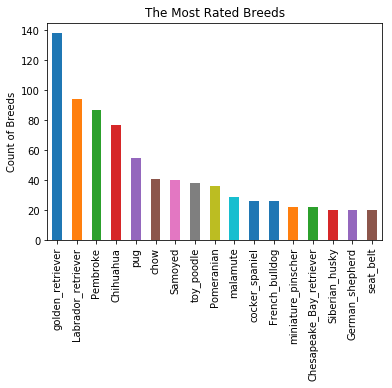

In [56]:
top=df_master.groupby('p1').filter(lambda x: len(x) >= 20)
top['p1'].value_counts().plot(kind = 'bar')
plt.title('The Most Rated Breeds');
plt.ylabel('Count of Breeds');


The plot above shows the top 10 dog breeds ranked by aggregate favourite counts. It looks very similar to the barplot ealier of top 10 dog breeds ranked by tweet, and in fact the top 4 dog breeds are the same. This also makes sense, as these dogs have the highest number of tweets.

Both groups have these 8 dog breeds in common:



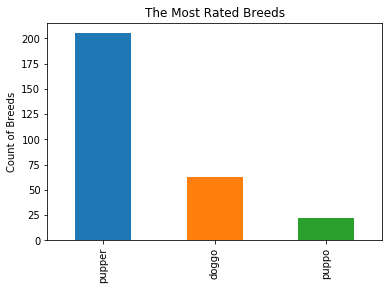

In [57]:
#popular dog type
top=df_master.groupby('dog_type').filter(lambda x: len(x) >= 20)
top['dog_type'].value_counts().plot(kind = 'bar')
plt.title('The Most Rated Breeds');
plt.ylabel('Count of Breeds');


### this polt shows that the pupper is the most common types of the dogs 

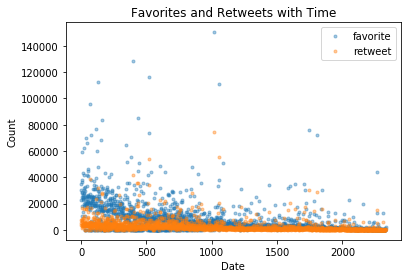

In [59]:
# Favorites and retweets trend over time
tweet_json[['favorite', 'retweet']].plot(style = '.', alpha = 0.4)
plt.title('Favorites and Retweets with Time')
plt.xlabel('Date')
plt.ylabel('Count');


##### this polt show how retweets and favorit effected by time

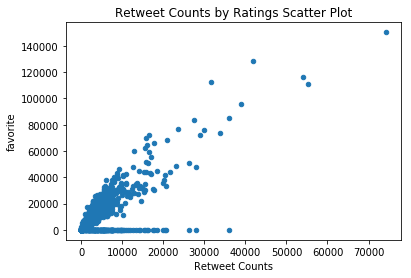

In [63]:
#Retweet Counts by Ratings Scatter Plot
tweet_json.plot(x='retweet', y='favorite', kind='scatter')
plt.xlabel('Retweet')
plt.ylabel('favorite')
plt.title('Retweet Counts by Ratings Scatter Plot')

fig = plt.gcf()
fig.savefig('output3.png',bbox_inches='tight');


##### this is polt shows that retweets the photo has the more favorite she get

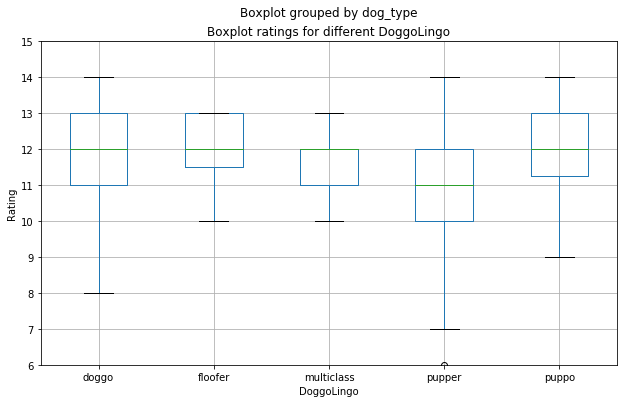

In [72]:
plt.rcParams['figure.figsize']=(10,6)
df_master[pd.notnull(df_master['dog_type'])].boxplot(column = ['rating'], by = ['dog_type'])
plt.ylim((6,15))
plt.title('Boxplot ratings for different DoggoLingo')
plt.xlabel('DoggoLingo')
plt.ylabel('Rating');


The box plot indicates that there is more consistency in rating puppo dogs high. There is also more consistency in rating the pupper dogs less than the others.